In [1]:
# run stopwatch
from tools import Stopwatch
stopwatch = Stopwatch()
start = stopwatch.start()

### Load libraries, functions, palette, theme

In [675]:
%run _libraries.ipynb

In [676]:
%run _functions.ipynb

In [4]:
current_dir = '03-arima-month'

In [5]:
previous_dir = '02-feature-engineering'

In [6]:
save_files = 'files/' + current_dir + '/'

In [7]:
load_files = 'files/' + previous_dir + '/'

In [8]:
save_img = 'docs/img/' + current_dir + '/'

In [9]:
session_name = current_dir

# Section III. ARIMA

## Load Saved Section if exists

## Load Data

In [10]:
train = datasets_dict = loadit(
    'train', dir=load_files)

In [11]:
valid = datasets_dict = loadit(
    'valid', dir=load_files)

In [12]:
test = datasets_dict = loadit(
    'test', dir=load_files)

## Stationarity

p< 0.05: Enough evidence to say, that process is stationarity

In [13]:
# NULL: non-stationarity
sm.tsa.stattools.adfuller(train['target1'])

(-28.686047970170506,
 0.0,
 47,
 30480,
 {'1%': -3.4305645620343594,
  '5%': -2.8616348306743395,
  '10%': -2.566820475464527},
 460471.5647015386)

### Autocorrelation

#### ACF - 40 period

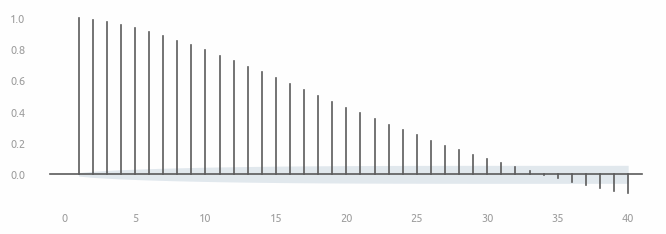

In [14]:
plot_acf(data=train['target1'], lags=40)

In [15]:
ts_acf_last_significant_index(train['target1'])

31

#### ACF - 300 period

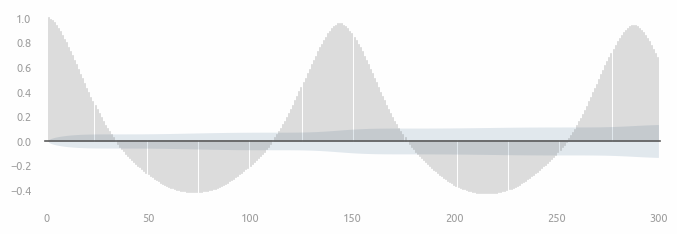

In [16]:
plot_acf(data=train['target1'], lags=300, transparency_lines=0.25)

#### PACF - 40 period

In [17]:
pacf = ts_acf_calculate(train['target1'], lags=36, partial=True)

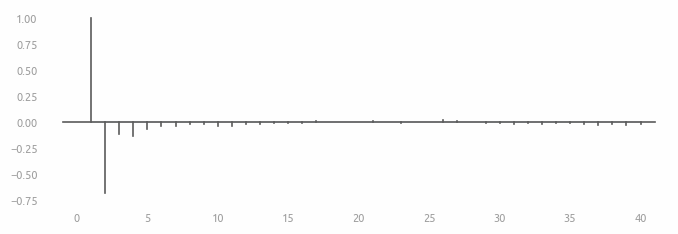

In [18]:
plot_acf(data=train['target1'], partial=True)

In [19]:
ts_acf_last_significant_index(data=train['target1'], partial=True)

13

## Trend and Seasonality of aggregated by Day data

In [20]:
stl_day = statsmodels.tsa.seasonal.STL(train.resample('d').mean()['target1']).fit()

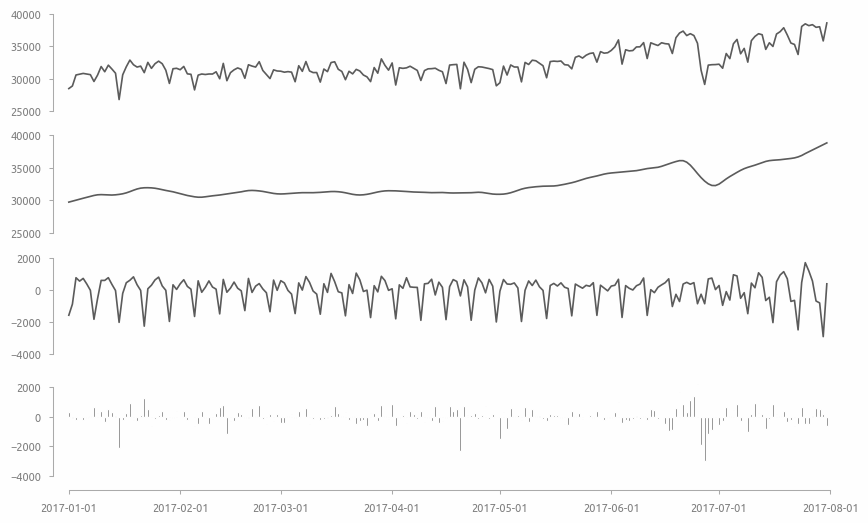

In [21]:
fig, ax = plt.subplots(4, 1, figsize=(10, 6), sharex=True)

ax[0].plot(stl_day.observed)
axis_rstyle(ax=ax[0], yticks=[25000, 40000, 5000])
ax[0].spines['bottom'].set_visible(False)
ax[0].tick_params(bottom=False)

ax[1].plot(stl_day.trend)
axis_rstyle(ax=ax[1], yticks=[25000, 40000, 5000])
ax[1].spines['bottom'].set_visible(False)
ax[1].tick_params(bottom=False)

ax[2].plot(stl_day.seasonal)
axis_rstyle(ax=ax[2], yticks=[-4000, 2000, 2000])
ax[2].spines['bottom'].set_visible(False)
ax[2].tick_params(bottom=False)

ax[3].bar(x=train.resample('D').mean().index, height=stl_day.resid, width=0.5)
axis_rstyle(ax=ax[3], yticks=[-4000, 2000, 2000])

plt.subplots_adjust(hspace=0.25)
plt.show()

## Design and datasets preparation

Use 3 datasets:

1. One rpevious month data: July data;
2. Manually chosen data: May-June;
3. Full data: January-July;

Preconditions:

1. Most closest to target data;
2. Data, that may have most similar tendency with target.

In [22]:
y1 = train.loc['2017-07-01':, 'target1'].copy()

In [23]:
y2 = train.loc['2017-05-01':'2017-06-30', 'target1'].copy()

In [24]:
y3 = train['target1'].copy()

In [25]:
y_true = valid['target1'].copy()

## Dataset: y1 - July data

### Model: ARIMA

#### ACF and PACF for differenced data

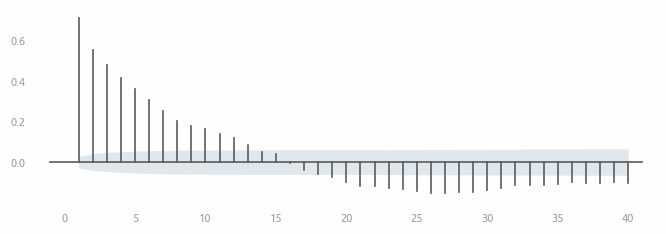

In [26]:
plot_acf(data=y1.diff(1)[1:])

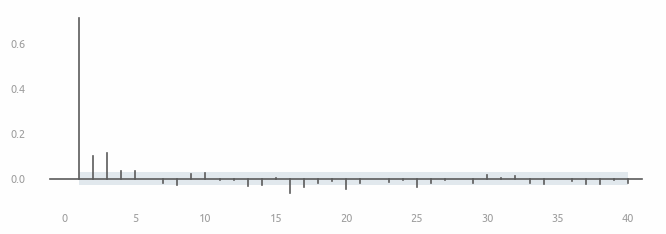

In [27]:
plot_acf(data=y1.diff(1)[1:], partial=True)

#### Model selection

In [28]:
arima311 = SARIMAX(
    y1, exog=None,
    order=(3,1,1),
    seasonal_order=(0, 0, 0, 0)
).fit(maxiter=1000, disp=False)

In [29]:
print(arima311.summary())

                               SARIMAX Results                                
Dep. Variable:                target1   No. Observations:                 4464
Model:               SARIMAX(3, 1, 1)   Log Likelihood              -33786.005
Date:                Fri, 29 Mar 2024   AIC                          67582.010
Time:                        21:28:23   BIC                          67614.028
Sample:                    07-01-2017   HQIC                         67593.296
                         - 07-31-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9631      0.107      9.015      0.000       0.754       1.173
ar.L2         -0.2024      0.064     -3.180      0.001      -0.327      -0.078
ar.L3          0.0751      0.017      4.526      0.0

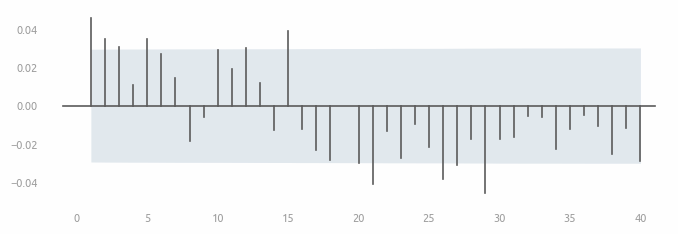

In [30]:
# should plot resid[d:], where d is d-order of ARIMA model
plot_acf(data=arima311.resid[1:])

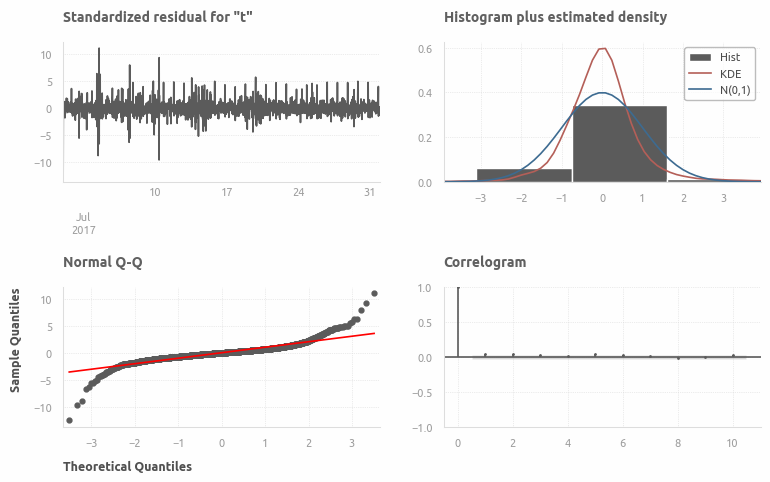

In [31]:
fig = arima311.plot_diagnostics(figsize=(9, 5), acf_kwargs={'markersize': 1})
plt.subplots_adjust(hspace=0.75)

In [32]:
model_auto = auto_arima(y1)

In [33]:
model_auto

ARIMA(order=(1, 1, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [34]:
arima_auto = SARIMAX(
    y1, exog=None,
    order=(1,1,2),
    seasonal_order=(0, 0, 0, 0)
).fit(maxiter=1000, disp=False)

In [35]:
print(model_auto.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 4464
Model:               SARIMAX(1, 1, 2)   Log Likelihood              -33786.090
Date:                Fri, 29 Mar 2024   AIC                          67580.181
Time:                        21:29:10   BIC                          67605.795
Sample:                    07-01-2017   HQIC                         67589.210
                         - 07-31-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8373      0.010     82.181      0.000       0.817       0.857
ma.L1         -0.2494      0.013    -19.557      0.000      -0.274      -0.224
ma.L2         -0.1273      0.014     -9.032      0.0

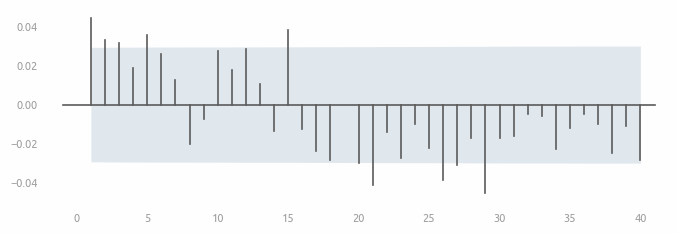

In [36]:
# should plot resid[d:], where d is d-order of ARIMA model
plot_acf(data=model_auto.resid()[1:])

In [37]:
test_LLR(arima311, arima_auto)

p-value: 1.0


In [38]:
arima_auto.aic < arima311.aic

True

#### Final ARIMA

In [39]:
arima = arima_auto

In [40]:
print(arima.summary())

                               SARIMAX Results                                
Dep. Variable:                target1   No. Observations:                 4464
Model:               SARIMAX(1, 1, 2)   Log Likelihood              -33786.090
Date:                Fri, 29 Mar 2024   AIC                          67580.181
Time:                        21:29:10   BIC                          67605.795
Sample:                    07-01-2017   HQIC                         67589.210
                         - 07-31-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8373      0.010     82.181      0.000       0.817       0.857
ma.L1         -0.2494      0.013    -19.557      0.000      -0.274      -0.224
ma.L2         -0.1273      0.014     -9.032      0.0

#### Forecast

In [41]:
len(y_true)

4464

In [42]:
arima_f = ts_arima_forecast(arima, steps=4464, data=y1.to_frame(), ci=[80, 95])

In [43]:
arima_f

,data,is_forecast,lower_ci80,upper_ci80,lower_ci95,upper_ci95
2017-07-01 00:00:00,36384.318940,0,NaN,NaN,NaN,NaN
2017-07-01 00:10:00,35689.036540,0,NaN,NaN,NaN,NaN
2017-07-01 00:20:00,34751.362130,0,NaN,NaN,NaN,NaN
2017-07-01 00:30:00,33954.019930,0,NaN,NaN,NaN,NaN
2017-07-01 00:40:00,33411.827240,0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
2017-08-31 23:10:00,34962.031134,1,-115727.747411,185651.809679,-195498.097609,265422.159877
2017-08-31 23:20:00,34962.031134,1,-115744.666420,185668.728689,-195523.973001,265448.035269
2017-08-31 23:30:00,34962.031134,1,-115761.583531,185685.645799,-195549.845489,265473.907757
2017-08-31 23:40:00,34962.031134,1,-115778.498742,185702.561011,-195575.715073,265499.777341


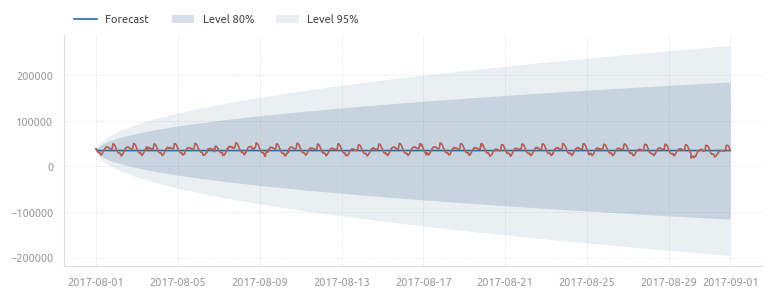

In [44]:
plt.figure(figsize=(9, 3))
ts_plot_arima_forecast(arima_f.iloc[-4464:, :])
plt.plot(y_true, color=saturate_color(palette[1], 1))
plt.show()

#### RMSE

In [45]:
root_mean_squared_log_error(y_true.shift(1)[1:], y_true[1:])

0.020071078804053313

In [46]:
arima_forecast = arima_f.loc[arima_f['is_forecast']==1, 'data']

In [47]:
root_mean_squared_log_error(arima_forecast, y_true)

0.20186637850241243

## Model 1: Monthly model

CV '2017-03' : '2017-07'   
Test '2017-08'

### ARIMA without exogs variables

In [343]:
len(train.loc['2017-03-01':]['month'].unique())

5

In [360]:
cv1_indexes_train, cv1_indexes_test = cv_split_indexes(
    data=train['target1'], start='2017-03-01', train_size=1,
    test_size=1, size_unit='months', n_splits=5, freq='10min')

In [561]:
cv1_indexes_train[-1]

DatetimeIndex(['2017-06-01 00:00:00', '2017-06-01 00:10:00',
               '2017-06-01 00:20:00', '2017-06-01 00:30:00',
               '2017-06-01 00:40:00', '2017-06-01 00:50:00',
               '2017-06-01 01:00:00', '2017-06-01 01:10:00',
               '2017-06-01 01:20:00', '2017-06-01 01:30:00',
               ...
               '2017-06-30 22:20:00', '2017-06-30 22:30:00',
               '2017-06-30 22:40:00', '2017-06-30 22:50:00',
               '2017-06-30 23:00:00', '2017-06-30 23:10:00',
               '2017-06-30 23:20:00', '2017-06-30 23:30:00',
               '2017-06-30 23:40:00', '2017-06-30 23:50:00'],
              dtype='datetime64[ns]', length=4320, freq='10min')

In [450]:
cv1_indexes_test[-1]

DatetimeIndex(['2017-07-01 00:00:00', '2017-07-01 00:10:00',
               '2017-07-01 00:20:00', '2017-07-01 00:30:00',
               '2017-07-01 00:40:00', '2017-07-01 00:50:00',
               '2017-07-01 01:00:00', '2017-07-01 01:10:00',
               '2017-07-01 01:20:00', '2017-07-01 01:30:00',
               ...
               '2017-07-31 22:20:00', '2017-07-31 22:30:00',
               '2017-07-31 22:40:00', '2017-07-31 22:50:00',
               '2017-07-31 23:00:00', '2017-07-31 23:10:00',
               '2017-07-31 23:20:00', '2017-07-31 23:30:00',
               '2017-07-31 23:40:00', '2017-07-31 23:50:00'],
              dtype='datetime64[ns]', length=4464, freq='10min')

In [363]:
cv1_results_month_model = cv_model_evaluation(
        data=train['target1'], start='2017-03-01', train_size=1, test_size=1, size_unit='months', n_splits=5, freq='10min',
        orders=[(1,1,2), (3,1,1)], fourier_periods=[[144], [144, 72]], fourier_orders=arange(1, 6, True))

Execution time: 0:55:43


In [397]:
cv1_month_models = cv1_results_month_model['models'].copy()

In [398]:
cv1_month_splits = pd.DataFrame(cv1_results_month_model['splits'])

In [400]:
cv1_month_splits

,model0,model1,model2,model3,model4,model5,model6,model7,model8,model9,...,model74,model75,model76,model77,model78,model79,model80,model81,model82,model83
0,0.161358,0.158710,0.067884,0.070892,0.080926,0.060975,0.158710,0.165300,0.152097,0.160680,...,0.063953,0.065643,0.066740,0.063696,0.063953,0.063953,0.063953,0.065644,0.066740,0.063697
1,0.177409,0.187798,0.086402,0.071900,0.083171,0.086681,0.187798,0.164109,0.169075,0.158737,...,0.075596,0.073975,0.074795,0.074157,0.075597,0.075597,0.075597,0.073975,0.074800,0.074158
2,0.203932,0.212398,0.113439,0.112755,0.107066,0.103540,0.212398,0.158930,0.178809,0.161201,...,0.099033,0.092232,0.095202,0.095622,0.099033,0.099033,0.099033,0.092232,0.095202,0.095622
3,0.157149,0.148114,0.160844,0.181485,0.186147,0.176830,0.148114,0.153020,0.148346,0.151041,...,0.176625,0.181015,0.181276,0.178911,0.176625,0.176625,0.176625,0.181015,0.181276,0.178911
4,0.228054,0.307688,0.261185,0.217016,0.205177,0.211505,0.307688,0.257869,0.264353,0.265159,...,0.181738,0.182103,0.182884,0.182837,0.181738,0.181738,0.181739,0.182103,0.182884,0.182839


In [399]:
cv1_month_splits_desriptive = pd.DataFrame(index=cv1_month_splits.columns)

In [401]:
cv1_month_splits_desriptive['mean'] = cv1_month_splits.mean()
cv1_month_splits_desriptive['std'] = cv1_month_splits.std()
# cv1_month_splits_desriptive['margin_up'] = \
#     cv1_month_splits_desriptive['mean'] + 1.96*cv1_month_splits_desriptive['std']/np.sqrt(5)
# cv1_month_splits_desriptive['margin_low'] = \
#     cv1_month_splits_desriptive['mean'] - 1.96*cv1_month_splits_desriptive['std']/np.sqrt(5)

In [402]:
cv1_month_splits_top_models = cv1_month_splits_desriptive.sort_values('mean')[:10].index

In [403]:
cv1_month_splits_top_models

Index(['model69', 'model63', 'model68', 'model62', 'model65', 'model71',
       'model70', 'model64', 'model73', 'model72'],
      dtype='object')

In [404]:
# top df without sort
cv1_month_splits_top = \
    cv1_month_splits.loc[:, cv1_month_splits.columns.isin(cv1_month_splits_top_models)].copy()

In [405]:
cv1_month_splits_desriptive_top = \
    cv1_month_splits_desriptive.loc[cv1_month_splits_desriptive.index.isin(cv1_month_splits_top_models)].copy()

In [406]:
cv1_month_splits_desriptive_top

,mean,std
model62,0.117468,0.056185
model63,0.117248,0.058007
model64,0.118249,0.057683
model65,0.118168,0.056665
model68,0.117468,0.056185
model69,0.117247,0.058008
model70,0.118249,0.057682
model71,0.118168,0.056665
model72,0.118944,0.059386
model73,0.118944,0.059386


In [407]:
cv1_month_splits_best_model = cv1_month_splits_desriptive_top.sort_values('mean').index[0]

In [408]:
cv1_month_splits_best_model

'model69'

In [410]:
for model in cv1_month_splits_desriptive_top.index:
    cv1_month_splits_desriptive_top.loc[model, 'lower'] = \
        ci_bootstrap(cv1_month_splits[model])['ci_min']
    cv1_month_splits_desriptive_top.loc[model, 'upper'] = \
        ci_bootstrap(cv1_month_splits[model])['ci_max']

In [411]:
cv1_month_splits_desriptive_top

,mean,std,lower,upper
model62,0.117468,0.056185,0.077605,0.163140
model63,0.117248,0.058007,0.074764,0.163130
model64,0.118249,0.057683,0.075999,0.164155
model65,0.118168,0.056665,0.074564,0.163745
model68,0.117468,0.056185,0.076269,0.163140
model69,0.117247,0.058008,0.075238,0.163131
model70,0.118249,0.057682,0.075998,0.164154
model71,0.118168,0.056665,0.074563,0.163745
model72,0.118944,0.059386,0.075839,0.164781
model73,0.118944,0.059386,0.073901,0.164781


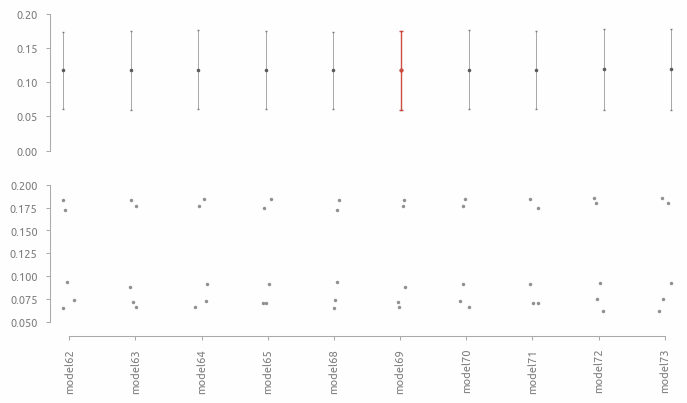

In [412]:
fig, ax = plt.subplots(2, 1, figsize=(8, 4))

ax[0].scatter(
    x = cv1_month_splits_desriptive_top.index,
    y = cv1_month_splits_desriptive_top['mean'],
    s=10)

ax[0].errorbar(
    x = cv1_month_splits_desriptive_top.index,
    y = cv1_month_splits_desriptive_top['mean'],
    yerr = cv1_month_splits_desriptive_top['std'],
    ls='none',
    lw=0.5,
    capsize=1,
    alpha=0.75)

# best model
ax[0].errorbar(
    x = cv1_month_splits_desriptive_top.loc[cv1_month_splits_best_model].name,
    y = cv1_month_splits_desriptive_top.loc[cv1_month_splits_best_model]['mean'],
    yerr = cv1_month_splits_desriptive_top.loc[cv1_month_splits_best_model]['std'],
    ls='none',
    lw=1,
    marker='.',
    markersize=4,
    capsize=1.5,
    color=saturate_color(palette[1], 1.5))

axis_rstyle(ax=ax[0], yticks=[0, 0.20, 0.05], ylim=[0, 0.20])
ax[0].spines['bottom'].set_visible(False)
ax[0].tick_params(bottom=False, labelbottom=False)

sns.stripplot(
    cv1_month_splits_top,
    s=5,
    color=palette[-2],
    ax=ax[1])

axis_rstyle(ax=ax[1])
# axis_add_xaxis(
#     offset_first_axis=40,
#     sepoffset=-1,
#     labels=[
#         ['144'] + ['144-42']*6 + ['144'] + ['144-42']*6,
#         ['(1, 1, 2)', '(3, 1, 1)']])

# ax[1].set_xticklabels(xticklabels*2, fontsize=5, ha='center')

plt.xticks(rotation=90)
plt.subplots_adjust(hspace=0.25)

In [413]:
# top 5 model smoothed data
cv1_month_splits_top_smoothed = smoothed(cv1_month_splits_top[cv1_month_splits_top_models], n=200)

In [420]:
cv1_month_splits_top_smoothed

,model69,model63,model68,model62,model65,model71,model70,model64,model73,model72
0.000000,0.065772,0.065773,0.064685,0.064687,0.070382,0.070382,0.066083,0.066084,0.061387,0.061388
0.020101,0.066554,0.066555,0.065336,0.065338,0.070737,0.070737,0.066824,0.066825,0.062490,0.062490
0.040201,0.067293,0.067295,0.065956,0.065957,0.071067,0.071067,0.067526,0.067527,0.063541,0.063542
0.060302,0.067992,0.067994,0.066545,0.066546,0.071373,0.071373,0.068190,0.068191,0.064542,0.064543
0.080402,0.068651,0.068652,0.067104,0.067106,0.071653,0.071653,0.068818,0.068819,0.065494,0.065495
...,...,...,...,...,...,...,...,...,...,...
3.919598,0.190952,0.190951,0.188882,0.188882,0.190530,0.190530,0.191327,0.191329,0.189458,0.189458
3.939698,0.189285,0.189284,0.187612,0.187612,0.189131,0.189131,0.189747,0.189749,0.187208,0.187208
3.959799,0.187507,0.187506,0.186250,0.186250,0.187633,0.187633,0.188061,0.188062,0.184828,0.184828
3.979899,0.185615,0.185614,0.184795,0.184795,0.186036,0.186036,0.186266,0.186268,0.182315,0.182315


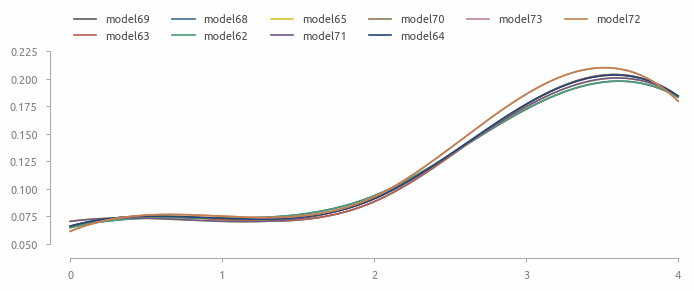

In [422]:
plt.plot(
    cv1_month_splits_top_smoothed
)
plt.legend(**legend_inline(), labels=cv1_month_splits_top_smoothed.columns);
ax_current().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
axis_rstyle(xticks=[0, 4, 1], offset_left=10)

In [472]:
cv1_month_period = train.loc['2017-03-01':'2017-07-30'].groupby('month').mean().copy()

In [483]:
cv1_month_period = train.loc['2017-03-01':'2017-07-30'].groupby('month').agg({'target1': ['mean', 'std']})

In [484]:
cv1_month_period.index = cv1_month_period.index - 3

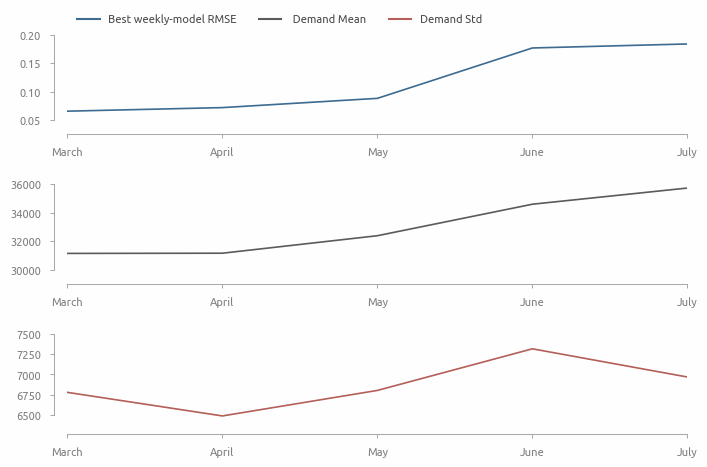

In [522]:
# top model

plt.figure(figsize=(8, 5))

plt.subplot(3, 1, 1)
plt.plot(
    cv1_month_splits_top[cv1_month_splits_best_model],
    color=palette[2],
    label=cv1_month_splits_best_model
)
# ax_current().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
axis_rstyle(xlim=[0, 4], xticks=[0, 4, 1], offset_left=10)
plt.xticks(arange(5), months_list[2:7])
# axis_remove_xaxis()
plt.legend(
    **legend_inline(3),
    **legend_create_handles(
        3,
        labels=['Best weekly-model RMSE', ' Demand Mean', 'Demand Std'],
        colors=[palette[2], palette[0], palette[1]]
    ));
# axis_remove_xaxis()

plt.subplot(3, 1, 2)
plt.plot(
    cv1_month_period['target1']['mean'],
    label='Mean'
)
axis_rstyle(xlim=[0, 4], xticks=[0, 4, 1], yticks=[30000, 36000, 2000], offset_left=10)
plt.xticks(arange(5), months_list[2:7])
# axis_remove_xaxis()

plt.subplot(3, 1, 3)
plt.plot(
    cv1_month_period['target1']['std'],
    color=palette[1],
    label='Std'
)
# ax_current().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
axis_rstyle(xlim=[0, 4], xticks=[0, 4, 1], yticks=[6500, 7500, 250], offset_left=10)

plt.xticks(arange(5), months_list[2:7])
plt.subplots_adjust(hspace=0.75)
plt.show()

In [609]:
arima1_month = cv1_month_models[cv1_month_splits_best_model]

In [610]:
arima1_month

((3, 1, 1), [144, 72], [4, 4])

In [611]:
cv1_month_splits_desriptive_top.loc[cv1_month_splits_best_model]

mean     0.117247
std      0.058008
lower    0.075238
upper    0.163131
Name: model69, dtype: float64

In [613]:
cv1_month_splits[cv1_month_splits_best_model]

0    0.065772
1    0.072025
2    0.088250
3    0.176579
4    0.183608
Name: model69, dtype: float64

### ARIMA with exogs variables

In [844]:
train.columns

Index(['temperature', 'humidity', 'windspeed', 'generaldiffuseflows',
       'diffuseflows', 'target1', 'target2', 'target3', 'minute', 'hour',
       'day', 'day_number', 'day_of_year', 'weekday', 'week', 'month',
       'year_month', 'year_day', 'count_elmnts_by_day', 'target1_diff',
       'target1_returns', 'target1_volatility', 'p', 'is_Friday', 'is_Sunday',
       'is_31', 'target1_cum_avg', 'target1_by_weekday', 'target1_by_minutes'],
      dtype='object')

In [845]:
# NULL: non-stationarity
sm.tsa.stattools.adfuller(train.loc['2017-07-01':, 'temperature'])

(-10.36173182087001,
 2.3867510600262185e-18,
 27,
 4436,
 {'1%': -3.4318249973120594,
  '5%': -2.8621917710771485,
  '10%': -2.5671169416654944},
 -1287.539719272837)

In [846]:
# NULL: non-stationarity
sm.tsa.stattools.adfuller(train.loc['2017-07-01':, 'target1_by_minutes'])

(-10.878385594286243,
 1.3137803449282866e-19,
 25,
 4438,
 {'1%': -3.4318243322143682,
  '5%': -2.8621914772569323,
  '10%': -2.567116785250736},
 67666.12586660299)

In [847]:
exog_vars = ['temperature', 'target1_by_minutes', 'is_Friday', 'is_Sunday', 'is_31']

In [848]:
exogs_df = train.loc['2017-02-01':, exog_vars].copy()

In [849]:
cv2_results_month_model = cv_model_evaluation(
        data=train['target1'], start='2017-03-01', train_size=1, test_size=1, size_unit='months', n_splits=5, freq='10min',
        orders=[(1,1,2), (3,1,1)], fourier_periods=[[144], [144, 72]], fourier_orders=arange(1, 6, True),
        exog_variables=exogs_df
)

Execution time: 1:16:53


In [850]:
cv2_month_models = cv2_results_month_model['models'].copy()

In [851]:
cv2_month_splits = pd.DataFrame(cv2_results_month_model['splits'])

In [852]:
cv2_month_splits

,model0,model1,model2,model3,model4,model5,model6,model7,model8,model9,...,model74,model75,model76,model77,model78,model79,model80,model81,model82,model83
0,0.144642,0.134895,0.070252,0.071610,0.081104,0.060188,0.134895,0.134828,0.131718,0.135882,...,0.062862,0.064889,0.066924,0.064294,0.062862,0.062862,0.062863,0.064889,0.066924,0.064304
1,0.141304,0.145834,0.082746,0.069456,0.079953,0.066855,0.145834,0.124266,0.131912,0.119542,...,0.073942,0.071810,0.071610,0.071517,0.073943,0.073943,0.073946,0.071810,0.071610,0.071516
2,0.169932,0.159308,0.104743,0.103657,0.099964,0.098790,0.159308,0.124054,0.137002,0.124888,...,0.095481,0.090494,0.093748,0.094344,0.095481,0.095481,0.095481,0.090494,0.093748,0.094344
3,0.167116,0.141889,0.156113,0.177573,0.183478,0.175609,0.141889,0.152955,0.148150,0.149751,...,0.175384,0.178692,0.179633,0.177406,0.175384,0.175384,0.175384,0.178692,0.179633,0.177406
4,0.216188,0.305427,0.289787,0.233046,0.220741,0.221533,0.305427,0.260313,0.262005,0.263899,...,0.185051,0.185115,0.186564,0.186535,0.185051,0.185051,0.185051,0.185115,0.186564,0.186535


In [853]:
cv2_month_splits_desriptive = pd.DataFrame(index=cv2_month_splits.columns)

In [854]:
cv2_month_splits_desriptive['mean'] = cv2_month_splits.mean()
cv2_month_splits_desriptive['std'] = cv2_month_splits.std()

In [855]:
cv2_month_splits_top_models = cv2_month_splits_desriptive.sort_values('mean')[:10].index

In [856]:
cv2_month_splits_top_models

Index(['model63', 'model69', 'model62', 'model68', 'model61', 'model66',
       'model67', 'model45', 'model64', 'model70'],
      dtype='object')

In [857]:
# top df without sort
cv2_month_splits_top = \
    cv2_month_splits.loc[:, cv2_month_splits.columns.isin(cv2_month_splits_top_models)].copy()

In [858]:
cv2_month_splits_desriptive_top = \
    cv2_month_splits_desriptive.loc[cv2_month_splits_desriptive.index.isin(cv2_month_splits_top_models)].copy()

In [859]:
cv2_month_splits_desriptive_top

,mean,std
model45,0.116549,0.060717
model61,0.116549,0.060717
model62,0.116400,0.057822
model63,0.116235,0.059180
model64,0.117240,0.059427
model66,0.116549,0.060718
model67,0.116549,0.060718
model68,0.116402,0.057820
model69,0.116235,0.059180
model70,0.117241,0.059427


In [860]:
cv2_month_splits_best_model = cv2_month_splits_desriptive_top.sort_values('mean').index[0]

In [861]:
cv2_month_splits_best_model

'model63'

In [862]:
for model in cv2_month_splits_desriptive_top.index:
    cv2_month_splits_desriptive_top.loc[model, 'lower'] = \
        ci_bootstrap(cv2_month_splits[model])['ci_min']
    cv2_month_splits_desriptive_top.loc[model, 'upper'] = \
        ci_bootstrap(cv2_month_splits[model])['ci_max']

In [863]:
cv2_month_splits_desriptive_top

,mean,std,lower,upper
model45,0.116549,0.060717,0.071839,0.165037
model61,0.116549,0.060717,0.071839,0.165036
model62,0.116400,0.057822,0.074152,0.164278
model63,0.116235,0.059180,0.074424,0.164275
model64,0.117240,0.059427,0.075314,0.165750
model66,0.116549,0.060718,0.071839,0.165037
model67,0.116549,0.060718,0.073261,0.165037
model68,0.116402,0.057820,0.074153,0.164278
model69,0.116235,0.059180,0.073413,0.164275
model70,0.117241,0.059427,0.075264,0.165750


In [864]:
arima2_month = cv2_month_models[cv2_month_splits_best_model]

In [865]:
arima2_month

((3, 1, 1), [144, 72], [3, 4])

In [866]:
cv2_month_splits_desriptive_top.loc[cv2_month_splits_best_model]

mean     0.116235
std      0.059180
lower    0.074424
upper    0.164275
Name: model63, dtype: float64

### Comparing models with and without exog variables

In [867]:
cv1_month_splits[cv1_month_splits_best_model]

0    0.065772
1    0.072025
2    0.088250
3    0.176579
4    0.183608
Name: model69, dtype: float64

In [868]:
cv2_month_splits[cv2_month_splits_best_model]

0    0.064393
1    0.069451
2    0.086942
3    0.173369
4    0.187021
Name: model63, dtype: float64

In [869]:
cv1_month_bootstrap_descriptive = \
    ci_bootstrap(cv1_month_splits[cv1_month_splits_best_model])

In [870]:
cv2_month_bootstrap_descriptive = \
    ci_bootstrap(cv2_month_splits[cv2_month_splits_best_model])

In [871]:
cv1_month_bootstrap_descriptive

{'statistic': 0.11724695611294629,
 'std': 0.058007874936142304,
 'ci_min': 0.07523798777013621,
 'ci_max': 0.1631308209982574,
 'margin': 0.04200896834281008}

In [872]:
cv2_month_bootstrap_descriptive

{'statistic': 0.11623512338875255,
 'std': 0.05918033187776734,
 'ci_min': 0.0744242854435797,
 'ci_max': 0.1642745812252791,
 'margin': 0.04181083794517286}

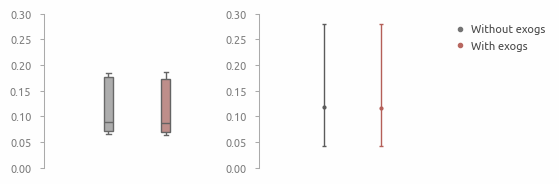

In [873]:
plt.subplots(1, 2, figsize=(5, 2))

plt.subplot(1, 2, 1)
sns.boxplot(
    x=0,
    y=cv1_month_splits[cv1_month_splits_best_model],
    width=0.15,
    color=alpha_color(palette[0], 0.5)
)
sns.boxplot(
    x=1,
    y=cv2_month_splits[cv1_month_splits_best_model],
    width=0.15,
    color=alpha_color(palette[1], 0.75)
)
plt.ylabel(None)
axis_rstyle(
    yticks=[0, 0.30, 0.05], 
    offset_bottom=0, xticks=[0, 1], xlim=[-1, 2], x_axis_hide=True)
ax_current().set_xticklabels(labels='')

plt.subplot(1, 2, 2)
plt.errorbar(
    x=0,
    y=cv1_month_bootstrap_descriptive['statistic'],
    yerr=np.array([[cv1_month_bootstrap_descriptive['ci_min']], [cv1_month_bootstrap_descriptive['ci_max']]]),
    marker='o',
    markersize=2,
    lw=1,
    capsize=1.5,
    color=alpha_color(palette[0], 1)
)
plt.errorbar(
    x=1,
    y=cv2_month_bootstrap_descriptive['statistic'],
    yerr=np.array([[cv2_month_bootstrap_descriptive['ci_min']], [cv2_month_bootstrap_descriptive['ci_max']]]),
    marker='o',
    markersize=2,
    lw=1,
    capsize=1.5,
    color=alpha_color(palette[1], 1)
)
ax_current().set_xticklabels(labels='')
axis_rstyle(
    yticks=[0, 0.30, 0.05], 
    offset_bottom=10, xticks=[0, 1], xlim=[-1, 2], x_axis_hide=True)
plt.legend(
    **legend_mid(),
    **legend_create_handles(
        2, 'point',
        colors=[alpha_color(palette[0], 0.85), alpha_color(palette[1], 0.95)],
        labels=['Without exogs', 'With exogs'])
)

plt.subplots_adjust(wspace=0.25)

In [874]:
arima_month = arima2_month

### Forecasts

In [875]:
arima_month_order = arima_month[0]
arima_month_fourier_period = arima_month[1]
arima_month_fourier_order = arima_month[2]

In [876]:
arima_month_order, arima_month_fourier_period, arima_month_fourier_order

((3, 1, 1), [144, 72], [3, 4])

#### August forecast

In [877]:
train_august_month = train.loc['2017-07-01':, 'target1'].copy()

In [878]:
train_august_month_exogs_df = train.loc['2017-07-01':, exog_vars].copy()

In [879]:
test_august_month = valid['target1'].copy()

In [880]:
test_august_month_exogs_df = valid.loc['2017-07-01':, exog_vars].copy()

In [881]:
train_august_month_exogs, test_august_month_exogs = \
    ts_arima_fourier_get_exogs(
        fourier_period=arima_month_fourier_period,
        fourier_order=arima_month_fourier_order,
        train_data=train_august_month,
        test_data=test_august_month)

In [882]:
test_august_month_exogs = test_august_month_exogs.join(
    test_august_month_exogs_df
)

In [883]:
model_month = fit_model_with_fourier(
    order=arima_month_order,
    fourier_period=arima_month_fourier_period,
    fourier_order=arima_month_fourier_order,
    train_data=train_august_month,
    exog=train_august_month_exogs_df
)

In [884]:
forecast_month = model_month.get_forecast(steps=len(test_august_month), exog=test_august_month_exogs)

In [885]:
root_mean_squared_log_error(forecast_month.predicted_mean, test_august_month)

0.05982815355708296

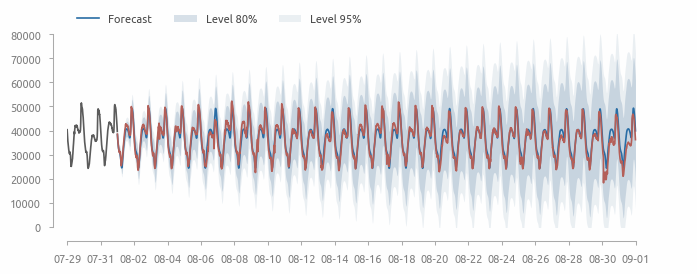

In [886]:
ts_plot_arima_forecast(
    model=model_month, steps=len(test_august_month),
    data=train_august_month.to_frame(), exog=test_august_month_exogs)
plt.plot(test_august_month)

ax_current().set_xlim(dt.date(2017, 7, 30))
ax_current().set_ylim(0, 80000)
ax_current().set_xticks(ticks=pd.date_range(start='2017-07-29', end='2017-09-01', freq='2d'))
ax_current().xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%m-%d'))
axis_rstyle(offset_left=10)

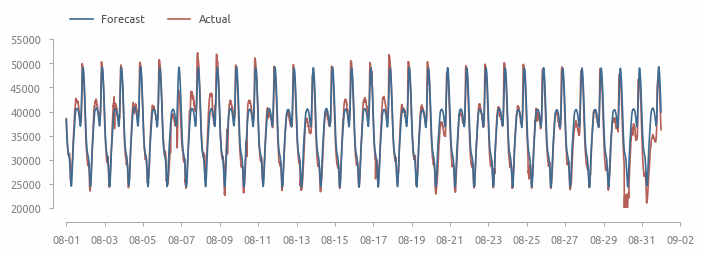

In [887]:
plt.plot(
    forecast_month.predicted_mean.index,
    forecast_month.predicted_mean,
    label='Forecast',
    color=palette[2], zorder=100)
plt.plot(
    valid['target1'],
    label='Actual',
    color=palette[1]);

ax_current().set_xticks(ticks=pd.date_range(start='2017-08-01', end='2017-09-02', freq='2d'))
ax_current().xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%m-%d'))
axis_rstyle(ylim=[20000, 60000])
plt.legend(**legend_inline(bbox_to_anchor=(0, 0.9)))
plt.show()

In [888]:
print(model_month.summary())

                               SARIMAX Results                                
Dep. Variable:                target1   No. Observations:                 4464
Model:               SARIMAX(3, 1, 1)   Log Likelihood              -33145.747
Date:                Mon, 08 Apr 2024   AIC                          66339.493
Time:                        13:10:23   BIC                          66493.179
Sample:                    07-01-2017   HQIC                         66393.669
                         - 07-31-2017                                         
Covariance Type:                  opg                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
sin(1,72)          -1416.8329     46.036    -30.776      0.000   -1507.063   -1326.603
cos(1,72)           1917.8559     54.625     35.110      0.000    1810.793    2024.919
sin(2,72)           

## Save Data

In [127]:
saveit(train, 'train', save_files)

File 'train.pkl' saved in directory 'files/03-arima/'


In [128]:
saveit(valid, 'valid', save_files)

File 'valid.pkl' saved in directory 'files/03-arima/'


In [129]:
saveit(test, 'test', save_files)

File 'test.pkl' saved in directory 'files/03-arima/'


In [364]:
saveit(cv1_results_week_model, 'cv1_results_month_model', save_files)

File 'cv_results_month_model.pkl' saved in directory 'files/03-arima/'


In [364]:
saveit(cv2_results_week_model, 'cv2_results_month_model', save_files)

File 'cv_results_month_model.pkl' saved in directory 'files/03-arima/'


### Save Session

In [130]:
save_session(session_name)

### Execution time

In [131]:
print(f'Execution time: {stopwatch.stop(start)}')

Execution time: 0:13:18
